# Built deep neural network with Numpy

In [123]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm

### Parameter Class 
##### A class storing the parameter values and gradients in a Layer. 

In [124]:
class Parameter():
    """
    A class used to store parameters in a Layer.

    ...

    Attributes
    ----------
    val : np.array
        Values of learnable parameters. (e.g. weight/bias in linear layer) 
    grad: np.array
        Values of gradients required for training.

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    """
    def __init__(self, dim_shape):
        self.dim_shape = dim_shape
        self.val = np.zeros(dim_shape)
        self.grad = np.zeros_like(self.val)

### Layer Class 
##### An abstract class for all required computational modules in this assignment.

In [125]:
class Layer():
    """
    An abstract class for all required computational modules.

    ...

    Attributes
    ----------
    val : np.array
        Values of learnable parameters. (e.g. weight/bias in linear layer) 
    grad: np.array
        Values of gradients required for training.

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    forward()
        forward computation module.
    backward()
        backpropagation module.
    parameters()
        Get trainable parameters/gradients.
    """
    def __init__(self):
        pass

    def init_param(self):
        pass

    def forward(self):
        pass

    def backward(self):
        pass

    def parameters(self):
        pass

### Linear Layer Class

In [126]:
class Linear(Layer):
    """
    Linear layer.

    ...

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    forward()
        forward computation module.
    backward()
        backpropagation module.
    parameters()
        Get trainable parameters/gradients of weight and bias for optimization.
    """
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = Parameter((input_dim, output_dim))
        self.bias = Parameter((output_dim,))
        self.init_param()
        self.input = None
        
    def init_param(self):
        self.weight.val = np.random.randn(self.input_dim, self.output_dim) * 0.1
        self.bias.val = np.zeros(self.output_dim)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weight.val) + self.bias.val.reshape(1, -1)

    def backward(self, backward_input):
        self.weight.grad = np.dot(self.input.T, backward_input)
        self.bias.grad = np.sum(backward_input, axis=0)
        d_input = np.dot(backward_input, self.weight.val.T)
        return d_input

    def parameters(self):
        return [self.weight, self.bias]

### ReLU Class

In [127]:
class ReLU(Layer):
    """
    ReLU activation unit.

    ...

    Methods
    -------
    forward()
        forward computation module.
    backward()
        backpropagation module.
    """
    def __init__(self):
        self.input = None

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, backward_input):
        return backward_input * (self.input > 0)


### Sigmoid Class

In [128]:
class Sigmoid(Layer):
    """
    Sigmoid activation unit.

    ...

    Methods
    -------
    forward()
        forward computation module.
    backward()
        backpropagation module.
    """
    def __init__(self):
        self.output = None

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
        
    def backward(self, backward_input):
        return backward_input * self.output * (1 - self.output)

### Binary Cross-Entropy Loss Class

In [129]:
class BinaryCrossEntropyLoss(Layer):
    def __init__(self):
        self.eps = 1e-15  # Small constant to avoid log(0)

    def forward(self, input, label):
        input = np.clip(input, self.eps, 1 - self.eps)
        return -np.mean(label * np.log(input) + (1 - label) * np.log(1 - input))
    
    def backward(self, input, label):
        input = np.clip(input, self.eps, 1 - self.eps)
        return -(label / input - (1 - label) / (1 - input)) / input.shape[0]

### Stochastic Gradient Descent Optimizer

In [130]:
class Optimizer_SGD():
    def __init__(self, param_list, learning_rate=0.01):
        self.parameters = param_list
        self.lr = learning_rate

    def step(self):
        for param in self.parameters:
            param.val -= self.lr * param.grad

### Model Class

In [131]:
class Model():
    """
    A deep neural network architecture for binary classification.

    ...

    Methods
    -------
    __init__()
        Define your own deep network by stacking modules above.
    forward()
        forward computation.
    backward()
        backpagation.
    parameters()
        return learnable parameters/gradients stored in all layers in model.
    """
    def __init__(self):
        self.layers = [
            Linear(2, 25),
            ReLU(),
            Linear(25, 50),
            ReLU(),
            Linear(50, 50),
            ReLU(),
            Linear(50, 25),
            ReLU(),
            Linear(25, 1),
            Sigmoid()
        ]

    def forward(self, input):
        x = input
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, backward_input):
        for layer in reversed(self.layers):
            backward_input = layer.backward(backward_input)
        return backward_input

    def parameters(self):
        params = []
        for layer in self.layers:
            if isinstance(layer, Linear):
                params.extend(layer.parameters())
        return params

### Generate and Visualize Training and Test Data

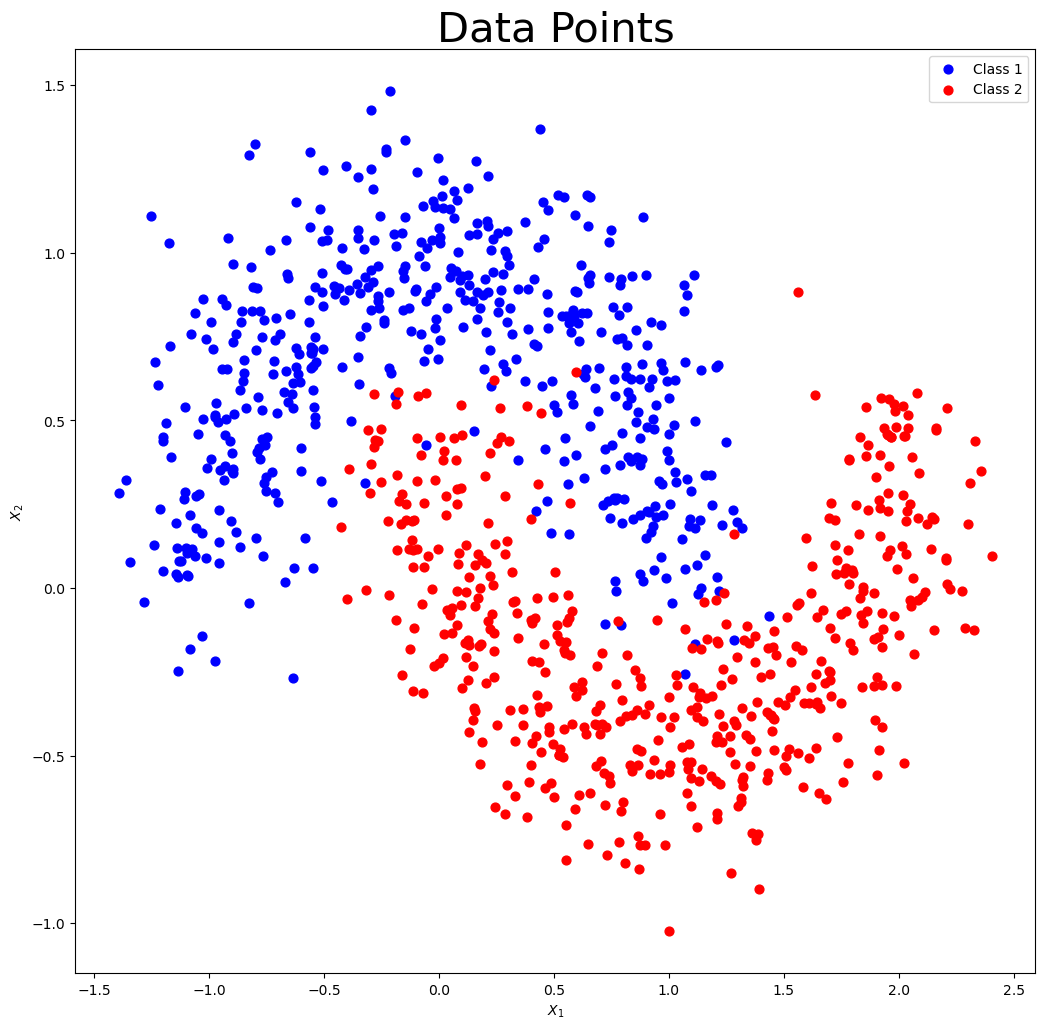

In [133]:
N_SAMPLES = 1000
TEST_SIZE = 0.1
# 2D data points for binary classification
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

def make_plot(X, y, plot_name):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], s=40, c = 'blue', label = 'Class 1')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], s=40, c = 'red', label = 'Class 2')
    plt.legend()
    plt.show()
make_plot(X, y, 'Data Points')

### Training Loop and Validating Model on Test Data

In [136]:
model = Model()
loss_fn = BinaryCrossEntropyLoss()
optimizer = Optimizer_SGD(model.parameters())

def train(X, Y, model, loss_fn, optimizer, epochs=10000):
    losses = []
    Y = Y.reshape(-1,1)
    
    for epoch in range(epochs):
        # Forward pass
        output = model.forward(X)
        loss = loss_fn.forward(output, Y)
        
        # Backward pass
        grad = loss_fn.backward(output, Y)
        model.backward(grad)
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
        losses.append(loss)
    
    return losses
    
def get_test_accuracy(model, X_test, y_test):
    X_test = X_test
    predictions = model.forward(X_test)
    predictions = (predictions >= 0.5).reshape(-1)
    accuracy = np.mean(predictions == y_test)
    return accuracy

losses = train(X_train, y_train, model, loss_fn, optimizer)
accuracy = get_test_accuracy(model, X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

Epoch 0, Loss: 0.6940
Epoch 1000, Loss: 0.6854
Epoch 2000, Loss: 0.5283
Epoch 3000, Loss: 0.2779
Epoch 4000, Loss: 0.2581
Epoch 5000, Loss: 0.2430
Epoch 6000, Loss: 0.2102
Epoch 7000, Loss: 0.1261
Epoch 8000, Loss: 0.0926
Epoch 9000, Loss: 0.0854
Test accuracy: 0.9600


### Visualize Decision Boundary

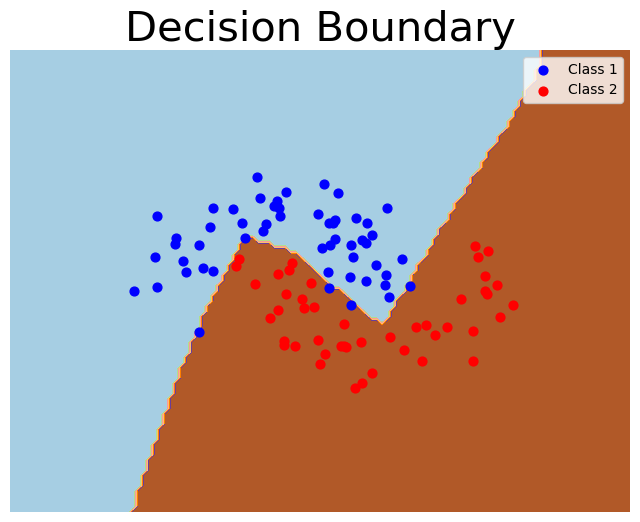

In [137]:
def plot_decision_boundary(model, X_train, Y_train, X_test, Y_test):
    # function to draw the model's decision boundary
    h = 0.05
    X = np.concatenate([X_train, X_test], axis = 0)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    input = np.stack([xx,yy], axis = -1).reshape(-1,2)
    pred = model.forward(input)
    index = pred >= 0.5
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.title('Decision Boundary', fontsize=30)
    ax.contourf(xx, yy, index.reshape(xx.shape), cmap=plt.cm.Paired)
    ax.axis('off')
    ax.scatter(X_test[Y_test == 0,0], X_test[Y_test == 0,1], s = 40,  c = 'blue', label = 'Class 1')
    ax.scatter(X_test[Y_test == 1,0], X_test[Y_test == 1,1], s = 40, c = 'red', label = 'Class 2')
    plt.legend()
    plt.show()

plot_decision_boundary(model, X_train, y_train, X_test, y_test)